# Parameter reconstruction for non-linear stress-strain relations

## Problem statement
The purpose of this project is to implement various machine learning techniques to reconstruct the model parameters from given stress-strain curves. It is a priori known that the stress-strain relation is given by an explicit *Ramberg-Osgood* model, which represents a non-linear relation between the stress $\sigma$ and the strain $\varepsilon$, namely
$$
\sigma = C \, \varepsilon^{1/n}\,.
$$
Herein, $C$ and $n$ denote the material parameters, which should be identified based on given stress-strain curves. 
 
## Data-driven approach
The implemented machine learning models learn the non-linear stress-strain relation through training data. Herein, each training sample corresponds to vector-valued stresses and strains, which are mapped to the corresponding model parameters. To this end, the following split is proposed:

*   features (vector-valued): $\varepsilon$, $\sigma$
*   labels: $C$, $n$

Note that the labels represent the target of a prediction, while the data generation process will be explained later. Since two parameters correspond to each stress-strain curve, the machine learning problem is consequently classified as a **multi-target regression**.


## Model requirements
The trained model should predict the material parameters from stress-strain curves, while the following requirements should be addressed through the implementation:

* noise in the stress-strain curves to represent experimental data,
* data points for the strain values are unevenly distributed,
* flexible adjustment of the number of data points in stress-strain curves.

## Solution procedure

* Analyze an exemplary stress-strain curve.
* Generating apropriate test and train data.
* Implement a machine learning model.
* Training the model and optimize hyperparameter.
* Evaluate the generalization performance on the test data.

# Setup

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools
import os
from scipy import stats
from scipy.optimize import curve_fit

## Custom plot style

In [2]:
# set custom matplotlib rc file 
url_rcfile = 'https://raw.githubusercontent.com/TheFerry10/ml-parameter-identification/master/seaborn-custom-style.mplstyle'
#path_rcfile = 'seaborn-custom-style.mplstyle'
mpl.style.use(url_rcfile)

# Uncomment the following lines, if you wish to use latex fonts in matplotlib
# figures. The first line installs latex fonts, while the second line activates
# the fonts in the matplotlib rc file

#!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng
mpl.rcParams['text.usetex'] = True


In [3]:
class CustomPlotStyle(object):
    def __init__(self, textwidth_in_inches=6.30):
        self.ASPECT_RATIO = 4/3
        self.TEXTWIDTH_LATEX = textwidth_in_inches
        self.SCALE = 1.0
        self.WIDTH = self.SCALE * self.TEXTWIDTH_LATEX
        self.HEIGHT = self.WIDTH / self.ASPECT_RATIO
        self.PALETTE = sns.color_palette(mpl.colors.TABLEAU_COLORS)
        self.MARKERS = ['o', 's', '^', 'v', 'D','P','X','*']

    def create_figure(self, width=None, height=None, aspect_ratio=None, width_scale=None):
        if width_scale is None:
            width_scale = self.SCALE
        if width is None:
            width = self.TEXTWIDTH_LATEX * width_scale
        if height is None:
            height = width / self.ASPECT_RATIO
        if aspect_ratio is not None:
            height =  width / aspect_ratio
        fig, ax = plt.subplots(figsize=(width, height), tight_layout=True)
        return fig, ax    
    
    def get_marker_cycle(self):
        return itertools.cycle(self.MARKERS)

    def get_color_cycle(self):
        return itertools.cycle(self.PALETTE)  


def create_label_without_line(label, ax):
    return ax.plot([],[],label=label, linewidth=0)

def set_figsize(width=6.3, aspect_ratio=4/3, width_scale=1.0):
    width = width * width_scale
    height =  width / aspect_ratio
    return (width, height)    

def save_fig(file_name, output_dir='', dpi=300, file_extensions=['.pdf','.png']):
    file_name = os.path.join(output_dir,file_name)
    for file_extension in file_extensions:
        plt.gcf().savefig(file_name + file_extension,dpi=dpi)
        
        
class PlotLabels(object):
    """Creating plot labels for convenience and use them globally"""
    def __init__(self):
        self.time = r'Time $t$ [s]'
        self.stress = r'Stress $\sigma$ [N/m$^2$]'
        self.strain = r'Strain $\varepsilon$ [-]'  

In [4]:
plotStyle = CustomPlotStyle(textwidth_in_inches=10.0)
plotLabels = PlotLabels()
sns.set_context("talk", font_scale=1.2)

In [5]:
PATH_TO_FIGURES = 'fig/'
if not os.path.isdir(PATH_TO_FIGURES):
    os.mkdir(PATH_TO_FIGURES)

 # Exploratory data analysis 

First, an exemplary stress-strain curve is loaded and the number of datapoints is extracted.  

In [6]:
url_dataset = 'https://raw.githubusercontent.com/TheFerry10/ml-parameter-identification/master/example-stress-strain-curve.csv'
#path_dataset = 'example-stress-strain-curve.csv'
df_stress_strain_curve = pd.read_csv(url_dataset)
NUM_DATAPOINTS, NUM_VARS  = df_stress_strain_curve.shape

The rolling mean and standard deviation corresponding corresponding to a fixed window size are calculated from the data. The averaged standard deviation will be later used to generate stress-strain curves, which obtain similar signal-to-noise values in the stress. 

In [7]:
window = 4
num_std = 1
df_stress_strain_curve["rollingMean"] = df_stress_strain_curve["sig"].rolling(window).mean()
df_stress_strain_curve["rollingStd"] = df_stress_strain_curve["sig"].rolling(window).std()
std_estimated_from_stress_strain_curve = df_stress_strain_curve["rollingStd"].mean()
print("Estimated averaged standard deviation:", std_estimated_from_stress_strain_curve)

Estimated averaged standard deviation: 0.5543221489961563


The stress-strain curve is visualized together with the rolling mean and error bands:

In [8]:
df_stress_strain_curve["lowErrorBand"] = df_stress_strain_curve["rollingMean"] - num_std * std_estimated_from_stress_strain_curve
df_stress_strain_curve["highErrorBand"] = df_stress_strain_curve["rollingMean"] + num_std * std_estimated_from_stress_strain_curve

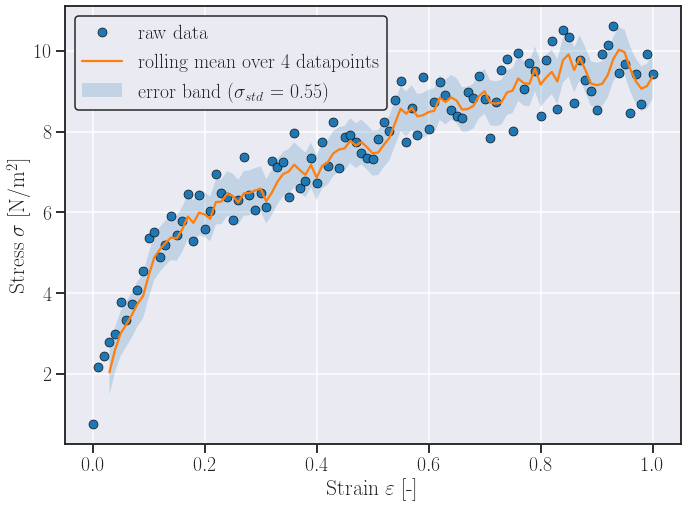

In [9]:
fig, ax = plotStyle.create_figure()
plt.plot("eps", "sig", data=df_stress_strain_curve, label='raw data', marker='o', linewidth=0)
plt.plot("eps", "rollingMean", data=df_stress_strain_curve, label=f'rolling mean over {window} datapoints')
plt.fill_between(x="eps", y1="highErrorBand", y2="lowErrorBand", data=df_stress_strain_curve, alpha=0.2,
                 label='error band ($\sigma_{std}$' + ' = {:.2f})'.format(std_estimated_from_stress_strain_curve))
plt.xlabel(plotLabels.strain)
plt.ylabel(plotLabels.stress)
plt.legend();
save_fig('compare-raw-data-rolling-mean',PATH_TO_FIGURES)

## Fitting the raw data
A non-linear least square method is used to fit the analytical model, ``get_stress_from_model``, to the given stress-strain curve. The optimization routine is implemented in the scientific computing libary Scipy. 

In [10]:
def get_stress_from_model(eps, C, n):
    """
    Implementation of the desired 
    non-linear stress-strain relation
    """
    return C*eps**(1.0/n)

In [11]:
popt, pcov = curve_fit(get_stress_from_model, df_stress_strain_curve["eps"], df_stress_strain_curve["sig"], p0=[5,2])

``pcov`` denotes the estimated covariance of the optimized parameters, ``popt``, while the elements on the diagonal provide the variances. To compute the standard deviation of the parameters, ``perr``, use: 

In [12]:
perr = np.sqrt(np.diag(pcov))
C_fit, n_fit = popt
C_fit_err, n_fit_err = perr

In [13]:
curve_fit_parameters = {'C': C_fit,
                       'n': n_fit,
                       'label': 'least squares fit ($C = {:.2f} \pm {:.2f}$, $n = {:.2f} \pm {:.2f}$)'.format(C_fit, C_fit_err, n_fit, n_fit_err),
                       'save_name': "compare-data-to-least-square-fit"}                       

In [14]:
def plot_raw_data_and_analytic_model(**kwargs):
    fig, ax = plotStyle.create_figure()
    plt.plot("eps", "sig", data=df_stress_strain_curve, label='raw data', marker='o', linewidth=0)
    plt.plot(df_stress_strain_curve["eps"], get_stress_from_model(df_stress_strain_curve["eps"], C=kwargs['C'], n=kwargs['n']), label=kwargs['label'])
    plt.legend()
    plt.xlabel(plotLabels.strain)
    plt.ylabel(plotLabels.stress)
    if kwargs['save_name'] != '':
        save_fig(kwargs['save_name'], PATH_TO_FIGURES)

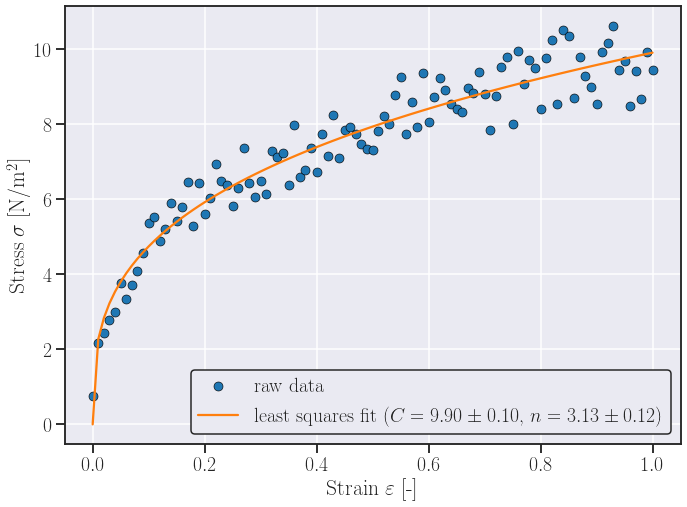

In [15]:
plot_raw_data_and_analytic_model(**curve_fit_parameters)

# Data generation

A data generator is implemented to obtain stress-strain curves. To this end, the analytical model (Ramberg-Osgood model) is used to produce stress values corresponding to the input values, namely, a given strain vector as well as the model parameters $C$ and $n$. In addition, Gaussian distributed noise is added to the analytically computed stress, while the standard deviation of the randomly added noise is chosen in accordance to the exemplary stress-strain curve, i.e. the average rolling standard deviation ``std_estimated_from_stress_strain_curve``. 
Each training data sample contains the strain and corresponding stress vectors as features, while the parameters for the generation, i.e. $C$ and $n$, are saved as targets (labels). 
The data generator is finally used to generate samples for various $C$ and $n$ value pairs. The $C$ and $n$ values are picked from uniform distributions in the range of $[C_{min}, C_{max}]$ and $[n_{min}, n_{max}]$, respectively. The number of datapoints is contant above all generated samples, however, the entries for the input vector $\varepsilon$ are randomly distributed (uniform distribution) between a minimum strain $\varepsilon_{min}$ and a maximum strain $\varepsilon_{max}$. As a results, training a model with such randomized data should lead to an enhanced generalization performance and therefore a flexible use of the final model.  


In [16]:
class StressStrainDataGenerator(object):
    def __init__(self, num_datapoints=101, eps_min=0.0, eps_max=1.0):
        self.num_datapoints = num_datapoints
        self.eps_min = eps_min 
        self.eps_max = eps_max
        self.std_noise = 0.0

    def get_stress_strain(self, C, n, add_noise=False, eps_linear_distributed=True):
        if eps_linear_distributed:
            eps = np.linspace(self.eps_min, self.eps_max, self.num_datapoints)
        else:
            eps = np.random.uniform(self.eps_min, self.eps_max, self.num_datapoints)
            eps = np.sort(eps)
        sig = get_stress_from_model(eps, C, n)
        if add_noise:
            sig += self.get_noise(len(sig), self.std_noise)       
        return np.array([eps, sig]) 

    def shuffle_stress_strain_datasets(self, data, labels):
        shuffle_index = np.random.permutation(len(labels))
        return data[shuffle_index], labels[shuffle_index]

    def get_noise(self, num_elements, sigma):
        noise = np.random.normal(0, sigma, num_elements)
        return noise        

    def generate_stress_strain_datasets(self, num_samples=100, C_range=[5,15], n_range=[2,5], shuffle=True, add_noise=True, eps_linear_distributed=False):
        generated_stress_strain_list = []
        generated_parameters_list = []
        for index_sample in range(num_samples):
                C = np.random.uniform(C_range[0],C_range[1])
                n = np.random.uniform(n_range[0],n_range[1])
                generated_stress_strain = self.get_stress_strain(C, n, add_noise, eps_linear_distributed)
                generated_stress_strain_list.append(generated_stress_strain)
                generated_parameters_list.append(np.array([C, n]))
        data = np.array(generated_stress_strain_list)
        targets = np.array(generated_parameters_list) 
        if shuffle:
            return self.shuffle_stress_strain_datasets(data, targets)  
        else:            
            return data, targets  


In [17]:
# The number of datapoints corresponds to the data set, which needs to be predicted.
stressStrainDataGenerator = StressStrainDataGenerator(num_datapoints=NUM_DATAPOINTS) 
stressStrainDataGenerator.std_noise =  std_estimated_from_stress_strain_curve 
data, targets = stressStrainDataGenerator.generate_stress_strain_datasets(num_samples=2000,
                                                                          C_range=[5,15],
                                                                          n_range=[2,5],
                                                                          shuffle=True,
                                                                          add_noise=True,
                                                                          eps_linear_distributed=False)

Now some of the generated stress-strain curves can be plotted. Note that the amount of plotted curves is restricted here to only a very few. 

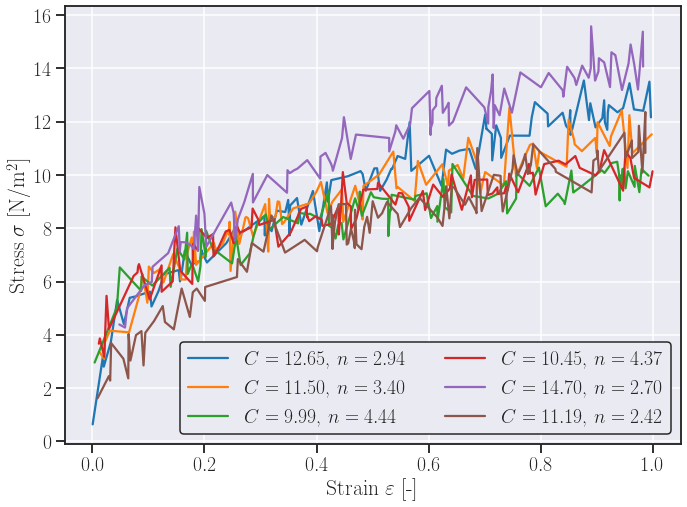

In [18]:
fig, ax = plotStyle.create_figure()
num_plotted_curves = 6
for sample_index in range(0, num_plotted_curves):
    x = data[sample_index][0]
    y = data[sample_index][1]
    label = '$C = {:.2f}$, $n = {:.2f}$'.format(*targets[sample_index])
    plt.plot(x, y, label=label)
plt.xlabel(plotLabels.strain)
plt.ylabel(plotLabels.stress)
plt.legend(ncol=2);
save_fig("sample-generated-curves", PATH_TO_FIGURES)

# Machine learning models

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error

With the generated data it is very easy to split it to training and testing samples.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.3)

The generated training data do not have the right shape for the further use in the machine learning models. To this end, the ``DataTransformer`` is intoduced to reshape the data into the compatible shape, i.e. ``(num_samples, num_variables*num_datapoints)``.  

In [21]:
class DataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        num_samples, num_variables, datapoints = X.shape
        X = X.reshape((num_samples, num_variables * datapoints))
        return X

Before the data is passed to a specific estimator, data transformations are carried out. First, the data is transformed using the ``DataTransformer``, while in a second step, the reshaped data is passed to a scaling function. For convenience, both steps are combined by defining apropriate pipelines. Finally, the data transformation pipeline is merged into a new pipeline, where the preprocessed data is now given to the specified estimator. 
Here, two distinct numeric transformers are defined to compare their performance during the hyperparameter optimization. 

For further information on pipelines in combination with hyperparameter optimization, check out the following project: 
https://www.kaggle.com/pedrodematos/titanic-a-complete-approach-to-top-6-rank

In [22]:
numeric_transformer_1 = Pipeline(steps=[('transform', DataTransformer()),
                                        ('scaler', MinMaxScaler())])

numeric_transformer_2 = Pipeline(steps=[('transform', DataTransformer()),
                                        ('scaler', StandardScaler())])

# Initializing data transformation step by choosing any of the above.
# Initializing modeling step of the pipeline with any model object.
pipe = Pipeline(steps=[('numeric_transformations', numeric_transformer_1), 
                       ('reg', RandomForestRegressor())]) 

## Train models and optimize hyperparameters

In the following, a predefined amount of hyperparameters are optimized through the Scikit-Learn class ``RandomSearchCV``. The parameter space is given by the following set:  

In [23]:
# grid search parameters:
params_distributions = [{'numeric_transformations': [numeric_transformer_1, numeric_transformer_2],
                         'reg': [RandomForestRegressor()],
                         'reg__n_estimators': stats.randint(50, 300),
                         'reg__criterion': ['mse']},
               
                        {'numeric_transformations': [numeric_transformer_1, numeric_transformer_2],
                         'reg': [MultiOutputRegressor(SVR())],
                         'reg__estimator__kernel': ['linear','rbf'],
                         'reg__estimator__C': stats.uniform(loc=1, scale=9)}]              

In [24]:
best_model_pipeline = RandomizedSearchCV(pipe, params_distributions, n_iter=5, 
                                         n_jobs=1, cv=3, random_state=42,
                                         scoring='neg_mean_squared_error',
                                         verbose=1)

Finally, the estimators are fitted to the training data, while the hyperparameters are optimized through the random search algorithm.

In [25]:
best_model_pipeline.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.3min finished


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('numeric_transformations',
                                              Pipeline(steps=[('transform',
                                                               DataTransformer()),
                                                              ('scaler',
                                                               MinMaxScaler())])),
                                             ('reg', RandomForestRegressor())]),
                   n_iter=5, n_jobs=1,
                   param_distributions=[{'numeric_transformations': [Pipeline(steps=[('transform',
                                                                                      DataTransformer()),
                                                                                     ('scaler',
                                                                                      MinMaxScaler())]),
                                                             

The results of the best model found by the random search read:

In [26]:
print("\n\n#---------------- Best Data Pipeline found in RandomSearchCV  ----------------#\n\n", best_model_pipeline.best_estimator_[0])
print("\n\n#---------------- Best Regressor found in RandomSearchCV  ----------------#\n\n", best_model_pipeline.best_estimator_[1])
print("\n\n#---------------- Best Estimator's average Accuracy Score on CV (validation set) ----------------#\n\n", best_model_pipeline.best_score_)



#---------------- Best Data Pipeline found in RandomSearchCV  ----------------#

 Pipeline(steps=[('transform', DataTransformer()), ('scaler', MinMaxScaler())])


#---------------- Best Regressor found in RandomSearchCV  ----------------#

 MultiOutputRegressor(estimator=SVR(C=6.41003510568888))


#---------------- Best Estimator's average Accuracy Score on CV (validation set) ----------------#

 -0.04412267875878858


## Model evaluation

The Root-Mean-Square-Error (RMSE) between predicted and actual targets (labels) is in the following calculated on the train and test data. Note that the model did not seen the test data in the training process. In addition to a small RMSE on the training data, a similar error on the test data indicates a good generalization performance of the trained model. 

In [27]:
rmse_ml_train = np.sqrt(mean_squared_error(best_model_pipeline.predict(X_train), y_train))
rmse_ml_test = np.sqrt(mean_squared_error(best_model_pipeline.predict(X_test), y_test))
print('RMSE on train data = ',rmse_ml_train)
print('RMSE on test data = ',rmse_ml_test)

RMSE on train data =  0.08386627482258074
RMSE on test data =  0.19140806545793138


Finally, let's predict the model parameters related to the stress-strain curve, which has been analyzed in the beginning. In order to predict the parameters, the data needs to be reshaped according to expected input shape of the pipeline, i.e. ``(1, NUM_VARS, NUM_DATAPOINTS)``. Note that the batch size is here equal to 1. 

In [28]:
def transform_stress_strain_curve(df=df_stress_strain_curve):
    stress_strain_curve_transformed = df_stress_strain_curve[["eps", "sig"]].values.transpose()
    stress_strain_curve_transformed = np.expand_dims(stress_strain_curve_transformed, axis=0)
    return stress_strain_curve_transformed

stress_strain_curve_transformed = transform_stress_strain_curve(df_stress_strain_curve)

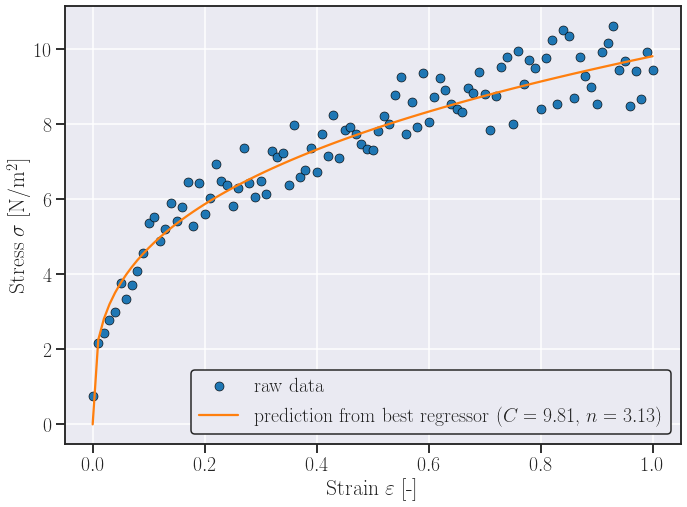

In [29]:
C_pred, n_pred = best_model_pipeline.predict(stress_strain_curve_transformed)[0]

best_model_parameters = {"C": C_pred,
                         "n": n_pred,
                         "label": "prediction from best regressor ($C = {:.2f}$, $n = {:.2f}$)".format(C_pred, n_pred),
                         "save_name": "compare-raw-data-ml-regressor"}
                         
plot_raw_data_and_analytic_model(**best_model_parameters)

# Neural Network approach

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.callbacks
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

## Model setup

A flexible function to create a Neural Network (NN) with two hidden layers is presented in the following. The number of neurons per hidden layer can be adjusted among other parameters, e.g. the learning rate.

In [31]:
def build_keras_model(num_input=202, num_output=2, act='relu', learning_rate=0.001, dropout_rate=0.2, hidden_layer_size_1=50, hidden_layer_size_2=25):  
    model = keras.Sequential()
    model.add(layers.Dropout(dropout_rate, input_shape=(num_input,)))
    model.add(layers.Dense(hidden_layer_size_1, activation=act))
    model.add(layers.Dense(hidden_layer_size_2, activation=act))
    model.add(layers.Dense(num_output))

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In the following, a predefined amount of hyperparameters are optimized through Scikit-Learn class ``GridSearchCV``. To this end, the Keras model needs to be wrapped as a Scikit-Learn regressor through:

In [32]:
# pass in fixed parameters num_input and num_output
NN_reg = KerasRegressor(build_fn = build_keras_model,
                        num_input = NUM_DATAPOINTS*NUM_VARS,
                        num_output = NUM_VARS)

## Train Neural Network and optimize hyperparameters

Constant fit parameters, ``fit_params``, for the training process are defined, while the grid search parameters are specified through ``params_grid``. The grid search is performed across all combinations. 

In [33]:
# Set fixed parameters for the training process.
# Note these parameters could also be treated as 
# variable hyperparameters in the grid search.

fit_params = {'NN__batch_size': 100,
              'NN__verbose': 0,
              'NN__validation_split': 0.2}


# grid search parameters:

params_grid = [{'num_transformations': [numeric_transformer_2],
               'NN': [NN_reg],
               'NN__epochs': [500, 1000],
               'NN__hidden_layer_size_1': [50, 100],
               'NN__hidden_layer_size_2': [50, 100]}]

For convenience, the data transformation and the estimator are combined in a pipeline. Finally the grid search is initialized and fitted to the generated training data. 

In [34]:
NN_pipe = Pipeline(steps=[('num_transformations', numeric_transformer_2), 
                          ('NN', NN_reg)])

best_NN_pipeline = GridSearchCV(NN_pipe, 
                                param_grid = params_grid,
                                scoring='neg_mean_squared_error', 
                                cv=3,
                                n_jobs=1)

best_NN_pipeline.fit(X_train, y_train, **fit_params)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('num_transformations',
                                        Pipeline(steps=[('transform',
                                                         DataTransformer()),
                                                        ('scaler',
                                                         StandardScaler())])),
                                       ('NN',
                                        <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fb8b6ffa5d0>)]),
             n_jobs=1,
             param_grid=[{'NN': [<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fb8b6ffa5d0>],
                          'NN__epochs': [500, 1000],
                          'NN__hidden_layer_size_1': [50, 100],
                          'NN__hidden_layer_size_2': [50, 100],
                          'num_transformations': [Pipeline(steps=[('transform',
                                        

The results of the best NN found by the grid search read:

In [35]:
print("\n\n#---------------- Best Data Pipeline found in GridSearchCV  ----------------#\n\n", best_NN_pipeline.best_estimator_[0])
print("\n\n#---------------- Best Neural Network found in GridSearchCV  ----------------#\n\n")
print('Parameters:')
for param, value in best_NN_pipeline.best_params_.items():
    print('\t{}: {}'.format(param, value))
print("\n\n#---------------- Best Estimator's average score on CV (validation set) ----------------#\n\n", best_NN_pipeline.best_score_)



#---------------- Best Data Pipeline found in GridSearchCV  ----------------#

 Pipeline(steps=[('transform', DataTransformer()), ('scaler', StandardScaler())])


#---------------- Best Neural Network found in GridSearchCV  ----------------#


Parameters:
	NN: <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fb8b6ffa5d0>
	NN__epochs: 1000
	NN__hidden_layer_size_1: 50
	NN__hidden_layer_size_2: 50
	num_transformations: Pipeline(steps=[('transform', DataTransformer()), ('scaler', StandardScaler())])


#---------------- Best Estimator's average score on CV (validation set) ----------------#

 -0.06506663422057185


## Model evaluation

Again, the RMSEs are computed on the training and test data. Finally, the model parameters for the stress-strain curve analyzed in the beginning are predicted with the Neural Network.  

In [36]:
rmse_NN_train = np.sqrt(mean_squared_error(best_NN_pipeline.predict(X_train), y_train))
rmse_NN_test = np.sqrt(mean_squared_error(best_NN_pipeline.predict(X_test), y_test))
print('RMSE on train data = ', rmse_NN_train)
print('RMSE on test data = ', rmse_NN_test)

RMSE on train data =  0.1954486361634819
RMSE on test data =  0.25153596327241895


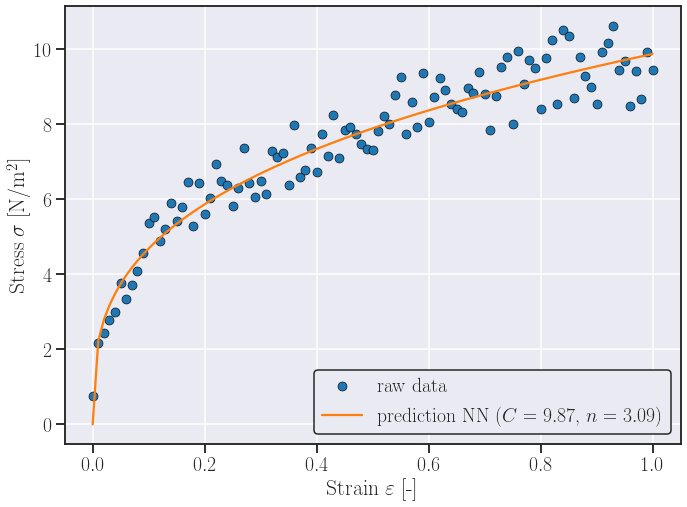

In [37]:
C_pred_NN, n_pred_NN = best_NN_pipeline.predict(stress_strain_curve_transformed)
estimated_parameters_NN = {"C": C_pred_NN,
                           "n": n_pred_NN,
                           "label": "prediction NN ($C = {:.2f}$, $n = {:.2f}$)".format(C_pred_NN, n_pred_NN),
                           "save_name": "compare-raw-data-NN-prediction"}

plot_raw_data_and_analytic_model(**estimated_parameters_NN)